In [1]:
import os, sys
import pickle 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
sys.path.insert(0,'../../LongTermEMG-master')

# 0. Prepare Data
* 20 participants total (exclude 10 and 11)
* data from 3DC armband (10 channels with 1000 Hz)
* 150 ms frames with overlap of 100 ms; band-pass filter between 20-495 Hz using fourth-order butterworth filter
* dataset dict
    * examples_training
    * labels_training
    * training_datetimes
    * highest_activations
    * examples_evaluation
    * labels_evaluation
    * evaluation_emg_timestamps
    * angles_and_timestamps
    * evaluation_datetimes
* feature_set_function = feature_extraction.getTSD applied to each window 
    * exclude 0 sEMG recordings 
    * [1] A. Al-Timemy, R. N. Khushaba, G. Bugmann, and J. Escudero, "Improving the Performance Against Force Variation of EMG Controlled Multifunctional Upper-Limb Prostheses for Transradial Amputees", IEEE Transactions on Neural Systems and Rehabilitation Engineering, DOI: 10.1109/TNSRE.2015.2445634, 2015.
    * [2] R. N. Khushaba, Maen Takruri, Jaime Valls Miro, and Sarath Kodagoda, "Towards limb position invariant myoelectric pattern recognition using time-dependent spectral features", Neural Networks, vol. 55, pp. 42-58, 2014.

In [2]:
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.prepare_dataset_utils import butter_bandpass_filter, \
    show_filtered_signal, load_timestamps_from_participant, get_angles_from_positions_3d_arm
from LongTermClassificationMain.PrepareAndLoadDataLongTerm import feature_extraction

In [3]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/PrepareAndLoadDataLongTerm")
print(os.listdir("../../"))
from handcrafted_features_prepare_from_from_raw_dataset import read_data_training

['longterm_dataset_3DC.zip', 'longterm_dataset_3DC', 'README.md', 'LongTermClassificationMain', 'datasets', 'TransferLearning', '.idea', 'Weights_TSD']


In [4]:
list_participant_training_1_to_skip = ["Participant0/Training1", "Participant0/Evaluation2", "Participant0/Evaluation3",
                                       "Participant2/Training1", "Participant2/Evaluation2", "Participant2/Evaluation3"]

In [5]:
# features_set_name = "TSD_features_set"
# feature_set_function = feature_extraction.getTSD
# read_data_training(path="../../datasets/longterm_dataset_3DC", features_set_name=features_set_name, \
#                 feature_set_function=feature_set_function)

# 1. Temporal-Spatial Descriptors Deep Network (TSD_DNN)
* input size = 128 x 3 x 1 = 384
* 3 fully connected layers with 200 neurons 
    * batch normalization
    * leaky ReLU (0.1)
    * dropout (0.5)
* mean cross entropy loss
* optimization = ADAM (lr = 0.002515, beta = (0.5, 0.999))
* lr_scheduler (1e-8)
* dataloader needs
    * examples_training
    * labels_training
   
   
### Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures
    * best_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict 
    * fine-tune from the previous training      

In [6]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_Spectrogram_fine_tuning
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [7]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_standard import test_TSD_DNN_on_training_sessions

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [8]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

algo_name = "11Gestures_standard_ConvNet_THREE_Cycles_TSD"
path_to_save_to = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"

filter_size = [200, 200, 200]      
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11                          
learning_rate = 0.002515

In [9]:
train_Spectrogram_fine_tuning(examples_datasets_train, labels_datasets_train, filter_size=None,
                              num_kernels=filter_size, number_of_cycle_for_first_training=4,
                              number_of_cycles_rest_of_training=4, path_weight_to_save_to=path_to_save_to,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              batch_size=128, spectrogram_model=False,
                              feature_vector_input_length=feature_vector_input_length,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2835, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2888, 385)
Participant:  0
Session:  0
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(20

/home/laiy/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


train Loss: 0.01102007 Acc: 0.54332386
val Loss: 0.00946779 Acc: 0.23642173
New best validation loss: 0.009467786874253148
Epoch 1 of 500 took 0.213s
Epoch 1/499
----------
train Loss: 0.00474644 Acc: 0.82528409
val Loss: 0.00789105 Acc: 0.37699681
New best validation loss: 0.007891046353422415
Epoch 2 of 500 took 0.210s
Epoch 2/499
----------
train Loss: 0.00355613 Acc: 0.86044034
val Loss: 0.00701236 Acc: 0.40894569
New best validation loss: 0.007012360393048856
Epoch 3 of 500 took 0.195s
Epoch 3/499
----------
train Loss: 0.00257248 Acc: 0.9037642
val Loss: 0.06854719 Acc: 0.10223642
Epoch 4 of 500 took 0.214s
Epoch 4/499
----------
train Loss: 0.00233468 Acc: 0.90980114
val Loss: 0.00667140 Acc: 0.4313099
New best validation loss: 0.006671398973312622
Epoch 5 of 500 took 0.275s
Epoch 5/499
----------
train Loss: 0.00199999 Acc: 0.92151989
val Loss: 0.00844331 Acc: 0.40255591
Epoch 6 of 500 took 0.259s
Epoch 6/499
----------
train Loss: 0.00184634 Acc: 0.92578125
val Loss: 0.0159425

train Loss: 0.00378108 Acc: 0.8647017
val Loss: 0.01610005 Acc: 0.26666667
New best validation loss: 0.016100049397302054
Epoch 1 of 500 took 0.243s
Epoch 1/499
----------
train Loss: 0.00217426 Acc: 0.91619318
val Loss: 0.00386366 Acc: 0.62857143
New best validation loss: 0.0038636563316224114
Epoch 2 of 500 took 0.233s
Epoch 2/499
----------
train Loss: 0.00188226 Acc: 0.92791193
val Loss: 0.01223792 Acc: 0.44444444
Epoch 3 of 500 took 0.234s
Epoch 3/499
----------
train Loss: 0.00166716 Acc: 0.93536932
val Loss: 0.00515250 Acc: 0.58730159
Epoch 4 of 500 took 0.202s
Epoch 4/499
----------
train Loss: 0.00143027 Acc: 0.94708807
val Loss: 0.01428993 Acc: 0.41587302
Epoch 5 of 500 took 0.188s
Epoch 5/499
----------
train Loss: 0.00126341 Acc: 0.95134943
val Loss: 0.05196617 Acc: 0.17142857
Epoch 6 of 500 took 0.188s
Epoch 6/499
----------
train Loss: 0.00125123 Acc: 0.9506392
val Loss: 0.00572349 Acc: 0.63492063
Epoch 7 of 500 took 0.194s
Epoch 7/499
----------
train Loss: 0.00121473 Ac

train Loss: 0.00099864 Acc: 0.9634233
val Loss: 0.00205173 Acc: 0.78996865
New best validation loss: 0.0020517278988159563
Epoch 4 of 500 took 0.190s
Epoch 4/499
----------
train Loss: 0.00096266 Acc: 0.96519886
val Loss: 0.00031202 Acc: 0.97492163
New best validation loss: 0.0003120150171850916
Epoch 5 of 500 took 0.189s
Epoch 5/499
----------
train Loss: 0.00085422 Acc: 0.96732955
val Loss: 0.00384555 Acc: 0.63636364
Epoch 6 of 500 took 0.192s
Epoch 6/499
----------
train Loss: 0.00091099 Acc: 0.96271307
val Loss: 0.01510661 Acc: 0.44827586
Epoch 7 of 500 took 0.188s
Epoch 7/499
----------
train Loss: 0.00090286 Acc: 0.96058239
val Loss: 0.01222827 Acc: 0.51410658
Epoch 8 of 500 took 0.190s
Epoch 8/499
----------
train Loss: 0.00079467 Acc: 0.9662642
val Loss: 0.00102827 Acc: 0.87774295
Epoch 9 of 500 took 0.235s
Epoch 9/499
----------
train Loss: 0.00075570 Acc: 0.96946023
val Loss: 0.00329184 Acc: 0.72100313
Epoch 10 of 500 took 0.224s
Epoch 10/499
----------
train Loss: 0.00071766

train Loss: 0.00257720 Acc: 0.89985795
val Loss: 0.00121934 Acc: 0.84735202
Epoch 5 of 500 took 0.246s
Epoch 5/499
----------
train Loss: 0.00204891 Acc: 0.91725852
val Loss: 0.00651926 Acc: 0.50778816
Epoch 6 of 500 took 0.220s
Epoch 6/499
----------
train Loss: 0.00200989 Acc: 0.92080966
val Loss: 0.00137153 Acc: 0.84735202
Epoch 7 of 500 took 0.199s
Epoch 7/499
----------
train Loss: 0.00173273 Acc: 0.93323864
val Loss: 0.00643391 Acc: 0.59190031
Epoch 8 of 500 took 0.195s
Epoch 8/499
----------
train Loss: 0.00165140 Acc: 0.93288352
val Loss: 0.00741499 Acc: 0.53894081
Epoch     9: reducing learning rate of group 0 to 5.0300e-04.
Epoch 9 of 500 took 0.208s
Epoch 9/499
----------
train Loss: 0.00142855 Acc: 0.94637784
val Loss: 0.00036469 Acc: 0.95015576
New best validation loss: 0.0003646880248996699
Epoch 10 of 500 took 0.192s
Epoch 10/499
----------
train Loss: 0.00132522 Acc: 0.9506392
val Loss: 0.00050798 Acc: 0.9376947
Epoch 11 of 500 took 0.204s
Epoch 11/499
----------
train 

In [10]:
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=filter_size, use_only_first_training=True,
                                  path_weights=path_to_save_to,
                                  feature_vector_input_length=feature_vector_input_length,
                                  algo_name=algo_name, gestures_to_remove=gestures_to_remove,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1902, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1928, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99,

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

TSD_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    TSD_acc[i] = acc
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
TSD_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,1.0,0.553471,0.62312,0.126984


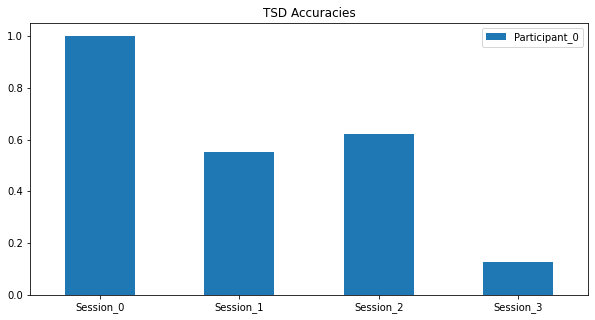

In [12]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. Domain Adverserial Neural Network (DANN)
* 2 domians : source(0) and target(1) (output_domain includes 2 features)
    * source / validation: labeled; first training
    * target: unlabeled; others
    * train using one source and one target
* start training using TSD_DNN model params 
* DANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = crossEntropyLoss(pred_domain_source, label_source_domain)
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_domain_target = 0.5 * domain_loss_weight * loss_domain_target
    * loss_main = loss_main_source + loss_domain_target
    * loss_domain = loss_domain_source + loss_domain_target
   
### Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD
    * beat_state_n.pt (n = # training session)
        * epoch: #epochs
        * model state_dict
        * optimizer state_dict
        * scheduler state_dict     

In [13]:
from LongTermClassificationMain.TrainingsAndEvaluations.ForTrainingSessions.TSD_DNN.train_tsd_dnn_standard import \
    test_TSD_DNN_on_training_sessions
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import train_DA_spectrograms
from LongTermClassificationMain.PrepareAndLoadDataLongTerm. \
    load_dataset_spectrogram_in_dataloader import load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.utils_training_and_evaluation import create_confusion_matrix, \
    long_term_classification_graph, long_term_pointplot

In [14]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from train_tsd_dnn_DA import test_network_DA_algorithm

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [15]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [16]:
num_neurons = [200, 200, 200]
feature_vector_input_length = 385
gestures_to_remove = [5, 6, 9, 10]
gestures_to_remove = None
number_of_class = 11
number_of_cycle_for_first_training = 4
number_of_cycles_rest_of_training = 4
learning_rate = 0.002515

path_weights_fine_tuning = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "DANN_THREE_CYCLES_11Gestures_TSD"

In [17]:
train_DA_spectrograms(examples_datasets_train, labels_datasets_train, filter_size=None,
                      num_kernels=num_neurons, algo_name=algo_name,
                      path_weights_fine_tuning=path_weights_fine_tuning,
                      gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                      number_of_cycle_for_first_training=number_of_cycle_for_first_training,
                      number_of_cycles_rest_of_training=number_of_cycles_rest_of_training,
                      batch_size=128, spectrogram_model=False,
                      feature_vector_input_length=feature_vector_input_length,
                      path_weights_to_save_to="Weights_TSD/weights_", learning_rate=learning_rate)

(4,)   0
SHAPE X:  (2816, 385)
(4,)   1
SHAPE X:  (2835, 385)
(4,)   2
SHAPE X:  (2864, 385)
(4,)   3
SHAPE X:  (2888, 385)
SHAPE SESSIONS:  (4,)
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, 

Accuracy source 0.984375, main loss classifier 0.120771, source classification loss 0.060026, loss domain distinction 0.653925, accuracy domain distinction 0.499822
VALIDATION Loss: 0.30377841 Acc: 0.8913738
New best validation loss:  0.30377840995788574
Epoch 1 of 500 took 0.486s
Accuracy source 0.983665, main loss classifier 0.108261, source classification loss 0.054762, loss domain distinction 0.471054, accuracy domain distinction 0.489702
VALIDATION Loss: 0.22052653 Acc: 0.93290735
New best validation loss:  0.2205265313386917
Epoch 2 of 500 took 0.425s
Accuracy source 0.983310, main loss classifier 0.103891, source classification loss 0.055297, loss domain distinction 0.366693, accuracy domain distinction 0.493608
VALIDATION Loss: 0.25127441 Acc: 0.91373802
Epoch 3 of 500 took 0.430s
Accuracy source 0.985440, main loss classifier 0.101039, source classification loss 0.052777, loss domain distinction 0.302303, accuracy domain distinction 0.494673
VALIDATION Loss: 0.17399973 Acc: 0.

Accuracy source 0.985440, main loss classifier 0.099132, source classification loss 0.049485, loss domain distinction 0.232702, accuracy domain distinction 0.488459
VALIDATION Loss: 2.64014244 Acc: 0.57188498
Epoch 7 of 500 took 0.671s
Accuracy source 0.985440, main loss classifier 0.101740, source classification loss 0.055618, loss domain distinction 0.226259, accuracy domain distinction 0.490589
VALIDATION Loss: 3.46765566 Acc: 0.51757188
Epoch 8 of 500 took 0.599s
Accuracy source 0.982955, main loss classifier 0.102261, source classification loss 0.057143, loss domain distinction 0.218917, accuracy domain distinction 0.495206
VALIDATION Loss: 2.64769125 Acc: 0.55910543
Epoch 9 of 500 took 0.450s
Accuracy source 0.985795, main loss classifier 0.099729, source classification loss 0.053336, loss domain distinction 0.216214, accuracy domain distinction 0.495561
VALIDATION Loss: 2.76676226 Acc: 0.54952077
Epoch 10 of 500 took 0.418s
Accuracy source 0.984020, main loss classifier 0.099183

In [18]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)   
test_network_DA_algorithm(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_neurons, path_weights_DA='Weights_TSD/weights_' + algo_name,
                              algo_name=algo_name,
                              path_weights_normal=path_weights_fine_tuning,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_class,
                              cycle_to_test=3)

(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1902, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1928, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99,

In [19]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

DANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    DANN_acc[i] = acc
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
DANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,1.0,0.77955,0.861842,0.190476


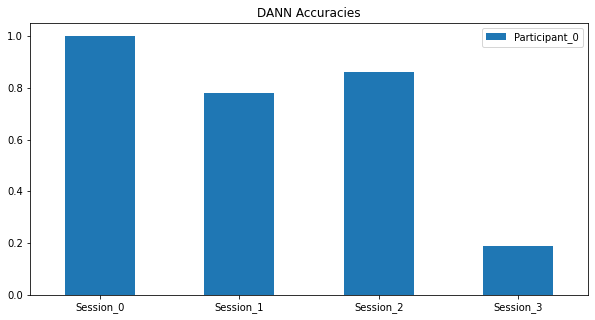

In [20]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN
* start training using TSD_DNN model params for the first training seesion, then using DANN model params 
* first traning = labeled, others = pseudo labels 
    * train using one lebaled and n psuedo labeled (n = #session)
* use all training data at once
* pseudo_labels_heuristic
    * window_stable_mode_length = 30 (hold stable for 1.5s)
    * percentage_same_gesture_now_stable = 65% (remove examples that are likely to generate false pseudo labels)
    * maximum_length_instability_gesture_transition = 40
    * maximum_length_instability_same_gesture = 40 (remove examples that are unstable for more than 2s)
* SCADANN loss (domain_loss_weight=1e-1)
    * loss_domain_source = ((1 - alpha) * crossEntropyLoss(pred_domain_source, label_source_domain))
    * loss_main_source = (0.5 * loss_source_class + domain_loss_weight * loss_domain_source)
    * loss_domain_target = 0.5 * (crossEntropyLoss(pred_domain_target, label_target_domain))
    * loss_main_target = (0.5 * loss_target_class + domain_loss_weight * loss_domain_target)
    * loss_main = loss_main_source + loss_main_target
    * loss_domain = loss_domain_source + loss_domain_target

   

### Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN
* beat_state_n.pt (n = # training session)
    * epoch: #epochs
    * model state_dict
    * optimizer state_dict
    * scheduler state_dict     

In [21]:
from LongTermClassificationMain.Models.TSD_neural_network import TSD_Network
from LongTermClassificationMain.TrainingsAndEvaluations.training_loops_preparations import load_checkpoint
from LongTermClassificationMain.PrepareAndLoadDataLongTerm.load_dataset_spectrogram_in_dataloader import \
    load_dataloaders_training_sessions
from LongTermClassificationMain.TrainingsAndEvaluations.self_learning.self_learning_utils import \
    generate_dataloaders_for_SCADANN
from LongTermClassificationMain.Models.model_training_self_learning import SCADANN_BN_training


In [22]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG-master/LongTermClassificationMain/TrainingsAndEvaluations/ForTrainingSessions/TSD_DNN")
print(os.listdir("../../"))
from SCADANN_TSD_DNN_training_session import run_SCADANN_training_sessions, test_network_SLADANN
batch_size = 256

['self_learning', 'utils_training_and_evaluation.py', 'training_loops_preparations.py', 'ForTrainingSessions', 'test_polar_plot.py', '__pycache__', 'ForEvaluationSessions']


In [23]:
with open("../../../Processed_datasets/TSD_features_set_training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)
examples_datasets_train = dataset_training['examples_training']
labels_datasets_train = dataset_training['labels_training']

In [24]:
num_neurons = [200, 200, 200]
learning_rate = 0.002515
feature_vector_input_length = 385
gestures_to_remove = None
number_of_classes = 11
percentage_same_gesture_stable = 0.65  # 0.65 for 11 gestures, 0.85 for 7 gestures
path_weight_to_save_to = "Weights_TSD/weights_THREE_CYCLES_11Gestures_SCADANN"
path_weights_start_with = "Weights_TSD/weights_DANN_THREE_CYCLES_11Gestures_TSD"
path_weights_Normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
algo_name = "SCADANN_THREE_CYCLES_11Gestures_TSD"

In [25]:
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_weight_to_save_to,
                              path_weights_Adversarial_training=path_weights_start_with,
                              path_weights_Normal_training=path_weights_Normal_training,
                              number_of_cycle_for_first_training=4, number_of_cycles_rest_of_training=4,
                              gestures_to_remove=gestures_to_remove, number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

(4,)   0
SHAPE X:  (3129, 385)
(4,)   1
SHAPE X:  (3150, 385)
(4,)   2
SHAPE X:  (3183, 385)
(4,)   3
SHAPE X:  (3209, 385)
participants_train =  1
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, e

BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.6907216494845361   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.21649484536082475   AFTER:  0.04054054054054054  len before:  97   len after:  74
BEFORE:  0.8762886597938144   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.8969072164948454   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7319587628865979   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.6804123711340206   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5520833333333334   AFTER:  1.0  len before:  96   len after:  72
ACCURACY MODEL:  0.8034920634920635   Accuracy pseudo: 0.9521563342318059  len pseudo:  2968    len predictions 3150
STARTING TRAINING
Accuracy total 0.899704, mai

Accuracy total 0.952492, main loss classifier 0.263632, source accuracy 0.977196 source classification loss 0.078843, target accuracy 0.927787 target loss 0.239389 accuracy domain distinction 0.500633 loss domain distinction 1.045166,
VALIDATION Loss: 0.16493253 Acc: 0.94781145
Epoch 25 of 500 took 0.733s
Accuracy total 0.952703, main loss classifier 0.268594, source accuracy 0.978041 source classification loss 0.074694, target accuracy 0.927365 target loss 0.252279 accuracy domain distinction 0.499789 loss domain distinction 1.051072,
VALIDATION Loss: 0.14554142 Acc: 0.94781145
Epoch 26 of 500 took 0.655s
Accuracy total 0.949958, main loss classifier 0.259254, source accuracy 0.978885 source classification loss 0.074205, target accuracy 0.921030 target loss 0.233960 accuracy domain distinction 0.500211 loss domain distinction 1.051716,
VALIDATION Loss: 0.15920632 Acc: 0.95117845
Epoch 27 of 500 took 0.665s
Accuracy total 0.953970, main loss classifier 0.258511, source accuracy 0.97466

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.979381443298969   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9278350515463918   AFTER:  1.0  len before:  97   len after:  69
BEFORE:  0.6888888888888889   AFTER:  1.0  len before:  90   len after:  90
BEFORE:  0.8556701030927835   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7731958762886598   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.4948453608247423   AFTER:  1.0  len before:  97   len after:  40
BEFORE:  0.7835051546391752   AFTER:  1.0  len before:  97   len after:  73
BEFORE:  0.9888888888888889   AFTER:  1.0  len before:  90   len after:  90
BEFORE:  0.7216494845360825   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.989

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


STARTING TRAINING
Accuracy total 0.877821, main loss classifier 0.564166, source accuracy 0.886285 source classification loss 0.421422, target accuracy 0.869358 target loss 0.461008 accuracy domain distinction 0.496094 loss domain distinction 1.229514,
VALIDATION Loss: 0.19306063 Acc: 0.9318569
New best validation loss:  0.19306062683463096
Epoch 2 of 500 took 0.635s
Accuracy total 0.891059, main loss classifier 0.481872, source accuracy 0.900174 source classification loss 0.347020, target accuracy 0.881944 target loss 0.385178 accuracy domain distinction 0.494575 loss domain distinction 1.157732,
VALIDATION Loss: 0.15311742 Acc: 0.94889267
New best validation loss:  0.15311742201447487
Epoch 3 of 500 took 0.630s
Accuracy total 0.909288, main loss classifier 0.431671, source accuracy 0.912326 source classification loss 0.306245, target accuracy 0.906250 target loss 0.332864 accuracy domain distinction 0.500434 loss domain distinction 1.121166,
VALIDATION Loss: 0.36549686 Acc: 0.8705281

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9893617021276596   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9587628865979382   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.9787234042553191   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.9896907216494846   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.5979381443298969   AFTER:  1.0  len before:  97   len after:  45
BEFORE:  0.23711340206185566   AFTER:  nan  len before:  97   len after:  0
BEFORE:  0.7835051546391752   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.7553191489361702   AFTER:  1.0  len before:  94   len after:  94
BEFORE:  0.8762886597938144   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.6701030927835051   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  1.0   AFTER:  1.0  len before:  97   len after:  97
BEFORE:  0.96

Accuracy total 0.791853, main loss classifier 0.868067, source accuracy 0.877790 source classification loss 0.448067, target accuracy 0.705915 target loss 1.059247 accuracy domain distinction 0.494141 loss domain distinction 1.144099,
VALIDATION Loss: 0.77908929 Acc: 0.75646552
New best validation loss:  0.7790892943739891
Epoch 11 of 500 took 0.523s
Accuracy total 0.800781, main loss classifier 0.861652, source accuracy 0.879464 source classification loss 0.426907, target accuracy 0.722098 target loss 1.066853 accuracy domain distinction 0.497489 loss domain distinction 1.147723,
VALIDATION Loss: 0.76153905 Acc: 0.77155172
New best validation loss:  0.7615390494465828
Epoch 12 of 500 took 0.577s
Accuracy total 0.801618, main loss classifier 0.851810, source accuracy 0.883371 source classification loss 0.409146, target accuracy 0.719866 target loss 1.066704 accuracy domain distinction 0.497210 loss domain distinction 1.138846,
VALIDATION Loss: 0.90338019 Acc: 0.76724138
Epoch 13 of 500

Accuracy total 0.816127, main loss classifier 0.778852, source accuracy 0.890067 source classification loss 0.386054, target accuracy 0.742188 target loss 0.948935 accuracy domain distinction 0.497768 loss domain distinction 1.113572,
VALIDATION Loss: 0.87083895 Acc: 0.74784483
Epoch 37 of 500 took 0.642s
Accuracy total 0.805246, main loss classifier 0.839343, source accuracy 0.882254 source classification loss 0.456307, target accuracy 0.728237 target loss 1.000353 accuracy domain distinction 0.496652 loss domain distinction 1.110124,
VALIDATION Loss: 0.75519289 Acc: 0.81681034
Epoch 38 of 500 took 0.624s
Accuracy total 0.810268, main loss classifier 0.781016, source accuracy 0.890625 source classification loss 0.385105, target accuracy 0.729911 target loss 0.956714 accuracy domain distinction 0.498884 loss domain distinction 1.101059,
VALIDATION Loss: 0.76555854 Acc: 0.84051724
Epoch 39 of 500 took 0.580s
Training complete in 0m 22s
['participant_1', 'participant_2', 'participant_0']

In [26]:
path_weights_normal_training = "Weights_TSD/weights_THREE_CYCLES_TSD_ELEVEN_Gestures"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_neurons, feature_vector_input_length=feature_vector_input_length,
                     path_weights_ASR=path_weight_to_save_to, path_weights_normal=path_weights_normal_training,
                     algo_name=algo_name, cycle_test=3, gestures_to_remove=gestures_to_remove,
                     number_of_classes=number_of_classes)

(4,)   0
SHAPE X:  (1746, 385)
(4,)   1
SHAPE X:  (1902, 385)
(4,)   2
SHAPE X:  (1912, 385)
(4,)   3
SHAPE X:  (1928, 385)
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=385, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=385, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): LinearBlocks(
      (fully_connected_1): Linear(in_features=200, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99,

In [27]:
results_filename = "results_tsd/predictions_training_session_" + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ground_truths = results[0]
predictions = results[1]

SCADANN_acc = np.zeros(ground_truths.shape)
for i, ground in np.ndenumerate(ground_truths):
    acc = np.mean(np.array(ground) == np.array(predictions[i]))
    SCADANN_acc[i] = acc
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc, 
                       columns = [f'Session_{i}' for i in range(ground_truths.shape[1])],
                        index = [f'Participant_{j}' for j in range(ground_truths.shape[0])])
SCADANN_df

,Session_0,Session_1,Session_2,Session_3
Participant_0,1.0,0.88743,0.960526,0.164332


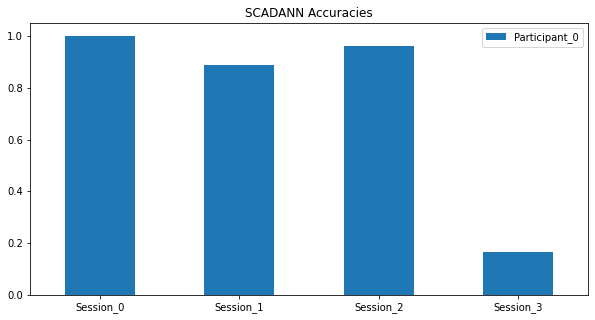

In [28]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion

In [29]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.575894
DANN,0.707967
SCADANN,0.753072


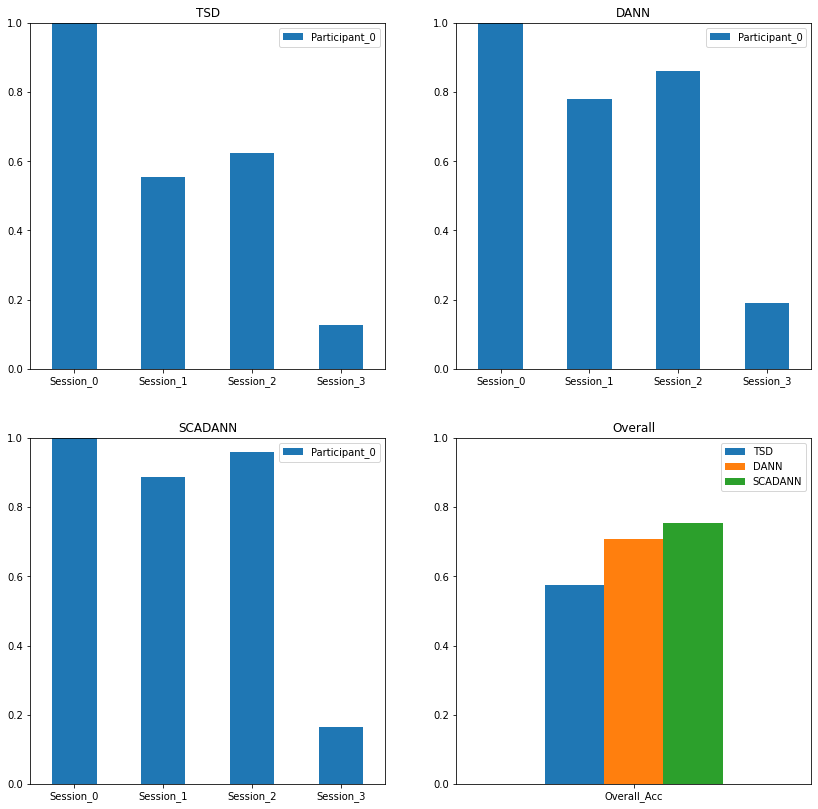

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])

Note for 2_only dataset:   
* result from STD -> DANN -> SCADANN  
    * 10.0 -> 17.9 -> 16.0
    * 17.2 -> 17.9 -> 16.9
    * 14.3 -> 16.5 -> 14.6
    * 12.7 -> 19.0 -> 16.4
* maybe this is just a bad data  
* percentage_same_gesture_stable=0.65
    * maybe too many unstable examples 